In [1]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from scipy.stats import pearsonr

from temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df, create_container_df

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sns.set(context = "notebook", style = "ticks", font="verdana", font_scale = 1.5)
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

In [2]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/hl4_plot/")

path_shiny_human = os.path.join(csv_path, "current_shiny_human.csv")
path_ephys = os.path.join(csv_path, "ephys_hIVSCC_MET.csv")

In [3]:
ephys_list = ["Vm(mV)", "Input Resistance(MΩ)", "Sag Fraction", "τ(s)", "LS AP up/downstoke", "Latency", "F-I Curve"]
region_list = ["FCx", "OCx", "PCx", "TCx"]

fields_ephys = ["name", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]

fields_shiny = ["cell_name", "roi", "cell_specimen_project", "Norm_Marker_Sum.0.4_label",
                "marker_sum_norm_label", "rna_amplification_pass_fail",
                "percent_cdna_longer_than_400bp", "amplified_quantity_ng", "sample_id", 
                "Tree_call", "seurat_prediction_score_label", "seurat_cluster_label",
                "broad_class_label", "subclass_label"]

shiny_dict = {"Norm_Marker_Sum.0.4_label" : "NMS Pass/Fail",
              "rna_amplification_pass_fail" : "RNA Amp Pass/Fail",
              "marker_sum_norm_label": "NMS score",
              "percent_cdna_longer_than_400bp" : "cDNA quality (%>400 bp)",
              "amplified_quantity_ng" : "Amplified content (ng)",
              "seurat_prediction_score_label": "Seurat prediction score"}

##### Filtering shiny

In [4]:
shiny_human = read_file(path_shiny_human, fields_shiny) #3592 rows
shiny_human.rename(columns=shiny_dict, inplace=True)

INFO:temp_funcs:Read file in as a pandas dataframe


In [5]:
shiny_human["NMS Pass/Fail"] = shiny_human["NMS Pass/Fail"].replace({True: "Pass", False: "Fail"})

In [6]:
shiny_human["region"] = pd.np.where(shiny_human.roi.str.contains("FCx"), "FCx", 
                                    pd.np.where(shiny_human.roi.str.contains("OCx"), "OCx", 
                                    pd.np.where(shiny_human.roi.str.contains("PCx"), "PCx",
                                    pd.np.where(shiny_human.roi.str.contains("TCx"), "TCx", "Unknown/Misc"))))

shiny_human["layer"] = pd.np.where(shiny_human.roi.str.contains("L1"), "L1", 
                                   pd.np.where(shiny_human.roi.str.contains("L2"), "L2",
                                   pd.np.where(shiny_human.roi.str.contains("L3"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L4"), "L4", 
                                   pd.np.where(shiny_human.roi.str.contains("L5"), "L5",
                                   pd.np.where(shiny_human.roi.str.contains("L6"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("L2-3"), "L2-3",
                                   pd.np.where(shiny_human.roi.str.contains("L3a"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3b"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3c"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L6a"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("LL1"), "LL1", 
                                   pd.np.where(shiny_human.roi.str.contains("LL2"), "LL2", 
                                   pd.np.where(shiny_human.roi.str.contains("LL3"), "LL3",
                                   pd.np.where(shiny_human.roi.str.contains("LL4"), "LL4", 
                                   pd.np.where(shiny_human.roi.str.contains("LL5"), "LL5", "unknown_layer"))))))))))))))))

In [7]:
ephys = read_file(path_ephys, fields_ephys) #1449 rows
ephys.rename(columns={"vrest": "Vm(mV)", "ri": "Input Resistance(MΩ)",
                       "sag" : "Sag Fraction", "tau": "τ(s)",
                       "upstroke_downstroke_ratio_long_square": "LS AP up/downstoke", "latency" : "Latency",
                       "f_i_curve_slope" : "F-I Curve"}, inplace=True)

INFO:temp_funcs:Read file in as a pandas dataframe


##### Human Layer 4 DF

In [8]:
h_l4 = filter_df(shiny_human, "layer", "L4")
h_l4 = create_cond_df(h_l4, "region", ["FCx", "OCx", "PCx", "TCx"]) #473 rows

INFO:temp_funcs:Filtered dataframe based on layer == L4
INFO:temp_funcs:Created a conditional dataframe based on region containing ['FCx', 'OCx', 'PCx', 'TCx']


In [9]:
merged = merge_dataframes(h_l4, ephys, "cell_name", "name", "inner") #379 rows
merged.dropna(subset=ephys_list, inplace=True) #311 rows

INFO:temp_funcs:Merged two pandas dataframe into one dataframe


In [10]:
#merged = filter_df(merged, "RNA Amp Pass/Fail", "Pass") #286 rows
#merged = filter_df(merged, "NMS Pass/Fail", "Pass") #270 rows

In [11]:
d = dict()
for region_name in region_list:
    d[region_name] = filter_df(merged, "region", region_name)

INFO:temp_funcs:Filtered dataframe based on region == FCx
INFO:temp_funcs:Filtered dataframe based on region == OCx
INFO:temp_funcs:Filtered dataframe based on region == PCx
INFO:temp_funcs:Filtered dataframe based on region == TCx


In [12]:
d["FCx"].count()

sample_id                  31
cell_name                  31
roi                        31
cDNA quality (%>400 bp)    31
RNA Amp Pass/Fail          31
Amplified content (ng)     31
cell_specimen_project      31
NMS score                  31
NMS Pass/Fail              31
seurat_cluster_label       31
Seurat prediction score    31
broad_class_label          31
subclass_label             31
Tree_call                  31
region                     31
layer                      31
name                       31
Vm(mV)                     31
Input Resistance(MΩ)       31
Sag Fraction               31
τ(s)                       31
LS AP up/downstoke         31
Latency                    31
F-I Curve                  31
dtype: int64

In [13]:
def return_subclass_list(new_region_df, visp_region_df, col_name, num=5):
    """Returns a subclass list with datapoints higher than "specified number
    Parameters:
        new_region_df:
        visp_region_df:
    Returns:
        sub_list:
    """
    
    new_region_sub_list = list()
    visp_sub_list = list()
    
    for n in new_region_df[col_name].unique():
        value = new_region_df[new_region_df[col_name] == n]["Vm(mV)"].count() >= num
        if value == True:
            new_region_sub_list.append(n)
    
    for n in visp_region_df[col_name].unique():
        value = visp_region_df[visp_region_df[col_name] == n]["Vm(mV)"].count() >= num
        if value == True:
            visp_sub_list.append(n)

    sub_list = sorted(list(set(new_region_sub_list) & set(visp_sub_list)))
    return sub_list

In [14]:
sub5_list = return_subclass_list(d["FCx"], d["TCx"], "subclass_label", 5)
sub5_list

['IT (L3-5)', 'IT (L4-6)', 'PVALB']

In [15]:
seurat5_list = return_subclass_list(d["FCx"], d["TCx"], "seurat_cluster_label", 5)
seurat5_list

['Exc L3-5 RORB ESR1', 'Inh L2-4 PVALB WFDC2']

In [16]:
d["FCx"].sort_values(by="subclass_label", inplace=True)
d["FCx"]

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sample_id,cell_name,roi,cDNA quality (%>400 bp),RNA Amp Pass/Fail,Amplified content (ng),cell_specimen_project,NMS score,NMS Pass/Fail,seurat_cluster_label,Seurat prediction score,broad_class_label,subclass_label,Tree_call,region,layer,name,Vm(mV),Input Resistance(MΩ),Sag Fraction,τ(s),LS AP up/downstoke,Latency,F-I Curve
172,P8S4_190514_358_A01,H19.03.312.11.04.01.01,FCx_L4,0.711,Pass,37.626604,hIVSCC-MET,0.923588,Pass,Exc L3-5 RORB FILIP1L,0.773098,Glutamatergic neuron,IT (L3-5),I1,FCx,L4,H19.03.312.11.04.01.01,-69.825682,174.312547,0.076178,32.635667,4.903720,0.06542,0.185000
286,PBS4_180705_504_A01,H18.06.359.11.03.01.04,FCx_L4,0.634,Pass,9.108855,hIVSCC-MET,0.468216,Pass,Exc L3-5 RORB TWIST2,0.314273,Glutamatergic neuron,IT (L3-5),PoorQ,FCx,L4,H18.06.359.11.03.01.04,-62.998070,310.937494,0.126707,27.556483,2.718748,0.02272,0.232857
283,P1S4_190425_004_A01,H19.03.310.11.05.01.05,FCx_L4,0.612,Pass,16.077523,hIVSCC-MET,0.875146,Pass,Exc L3-5 RORB TWIST2,0.813142,Glutamatergic neuron,IT (L3-5),I2,FCx,L4,H19.03.310.11.05.01.05,-64.006320,222.718850,0.083854,16.821364,3.222104,0.03468,0.378723
236,PFS4_190419_704_A01,H19.03.309.11.10.01.04,FCx_L4,0.711,Pass,34.136612,hIVSCC-MET,0.972368,Pass,Exc L3-5 RORB FILIP1L,0.459979,Glutamatergic neuron,IT (L3-5),I2,FCx,L4,H19.03.309.11.10.01.04,-70.277098,166.062430,0.176642,24.616710,3.667383,0.03766,0.218644
169,P8S4_190419_355_A01,H19.03.309.11.08.02.02,FCx_L4,0.718,Pass,31.777549,hIVSCC-MET,0.981459,Pass,Exc L3-5 RORB COL22A1,1.000000,Glutamatergic neuron,IT (L3-5),Core,FCx,L4,H19.03.309.11.08.02.02,-60.225854,300.770789,0.076595,42.861043,4.049080,0.03544,0.244860
162,PES4_190419_655_A01,H19.03.309.11.11.01.03,FCx_L4,0.657,Pass,27.926194,hIVSCC-MET,0.704652,Pass,Exc L3-5 RORB COL22A1,0.997444,Glutamatergic neuron,IT (L3-5),Core,FCx,L4,H19.03.309.11.11.01.03,-73.803561,360.787302,0.025340,47.465407,4.311797,0.04100,0.195000
158,PAS4_190514_458_A01,H19.03.312.11.01.01.03,FCx_L4,0.622,Pass,19.826293,hIVSCC-MET,0.940950,Pass,Exc L3-5 RORB COL22A1,0.666350,Glutamatergic neuron,IT (L3-5),Core,FCx,L4,H19.03.312.11.01.01.03,-59.833433,295.165390,0.127975,24.633506,4.137119,0.03032,0.493103
141,PES4_190425_654_A01,H19.03.310.11.06.01.04,FCx_L4,0.561,Pass,18.525937,hIVSCC-MET,0.820059,Pass,Exc L3-5 RORB ESR1,1.000000,Glutamatergic neuron,IT (L3-5),I1,FCx,L4,H19.03.310.11.06.01.04,-71.835605,254.437447,0.103056,22.860612,3.530150,0.03750,0.208621
111,P2S4_190514_054_A01,H19.03.312.11.05.01.03,FCx_L4,0.604,Pass,23.957173,hIVSCC-MET,0.863310,Pass,Exc L3-5 RORB ESR1,0.951914,Glutamatergic neuron,IT (L3-5),Core,FCx,L4,H19.03.312.11.05.01.03,-66.663722,363.793105,0.087010,15.895891,2.281154,0.01688,0.640000
366,PBS4_180621_507_A01,H18.26.403.11.06.01.09,FCx_L4,0.458,Fail,4.773120,hIVSCC-MET,0.088517,Fail,Inh L2-4 PVALB WFDC2,0.562296,Glutamatergic neuron,IT (L3-5),PoorQ,FCx,L4,H18.26.403.11.06.01.09,-75.511435,160.156250,0.126548,27.754678,4.512186,0.03314,0.151429


In [17]:
s_colors={"FCx": "#ef3b2c", "TCx": "#4292c6"}
org_region_list = ["FCx", "TCx"]

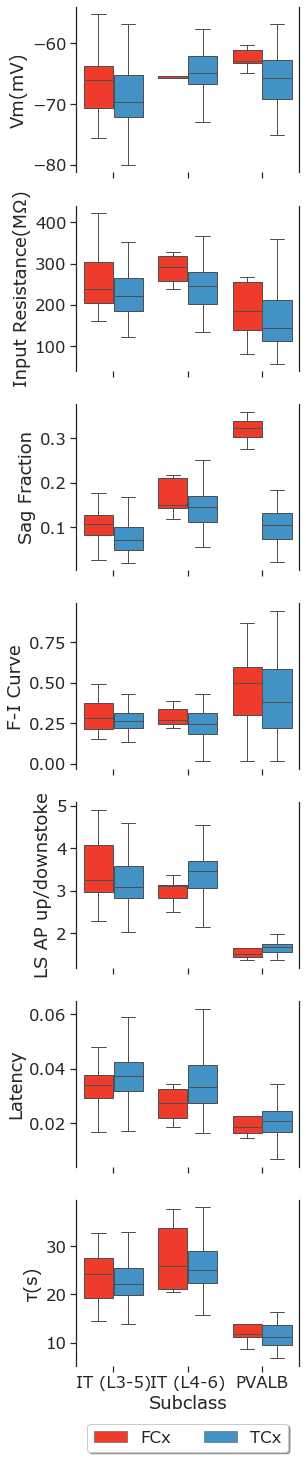

In [18]:
f, axes = plt.subplots(nrows=7, ncols=1, figsize=(4, 25))

ax = sns.boxplot(x="subclass_label", y="Vm(mV)", hue="region", data=merged, order=sub5_list, hue_order=org_region_list,
                  palette=s_colors, saturation=1, linewidth=1, showfliers=False, ax=axes[0])

ax1 = sns.boxplot(x="subclass_label", y="Input Resistance(MΩ)", hue="region", data=merged, order=sub5_list, hue_order=org_region_list,
                  palette=s_colors, saturation=1, linewidth=1, showfliers=False, ax=axes[1])

ax2 = sns.boxplot(x="subclass_label", y="Sag Fraction", hue="region", data=merged, order=sub5_list, hue_order=org_region_list,
                  palette=s_colors, saturation=1, linewidth=1, showfliers=False, ax=axes[2])

ax3 = sns.boxplot(x="subclass_label", y="F-I Curve", hue="region", data=merged, order=sub5_list, hue_order=org_region_list,
                 palette=s_colors, saturation=1, linewidth=1, showfliers=False, ax=axes[3])

ax4 = sns.boxplot(x="subclass_label", y="LS AP up/downstoke", hue="region", data=merged, order=sub5_list, hue_order=org_region_list,
                  palette=s_colors, saturation=1, linewidth=1, showfliers=False, ax=axes[4])

ax5 = sns.boxplot(x="subclass_label", y="Latency", hue="region", data=merged, order=sub5_list, hue_order=org_region_list,
                  palette=s_colors, saturation=1, linewidth=1, showfliers=False, ax=axes[5])

ax6 = sns.boxplot(x="subclass_label", y="τ(s)", hue="region", data=merged, order=sub5_list, hue_order=org_region_list,
                  palette=s_colors, saturation=1, linewidth=1, showfliers=False, ax=axes[6])

ax.legend_.remove()
ax1.legend_.remove()
ax2.legend_.remove()
ax3.legend_.remove()
ax4.legend_.remove()
ax5.legend_.remove()
ax6.legend_.remove()

ax.set(xticklabels=[])
ax1.set(xticklabels=[])
ax2.set(xticklabels=[])
ax3.set(xticklabels=[])
ax4.set(xticklabels=[])
ax5.set(xticklabels=[])

ax.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax4.set_xlabel("")
ax5.set_xlabel("")
ax6.set_xlabel("Subclass")
sns.despine(bottom=True, right=False)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=5)
plt.savefig(plot_path + "ephys_subclass_bxplot.jpeg", bbox_inches="tight")

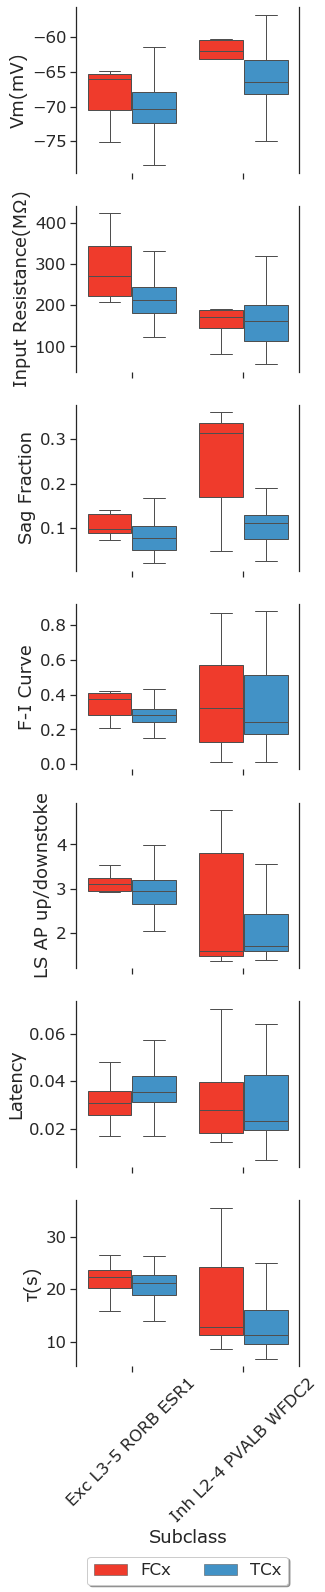

In [25]:
f, axes = plt.subplots(nrows=7, ncols=1, figsize=(4, 25))

ax = sns.boxplot(x="seurat_cluster_label", y="Vm(mV)", hue="region", data=merged, order=seurat5_list, hue_order=org_region_list,
                  palette=s_colors, saturation=1, linewidth=1, showfliers=False, ax=axes[0])

ax1 = sns.boxplot(x="seurat_cluster_label", y="Input Resistance(MΩ)", hue="region", data=merged, order=seurat5_list, hue_order=org_region_list,
                  palette=s_colors, saturation=1, linewidth=1, showfliers=False, ax=axes[1])

ax2 = sns.boxplot(x="seurat_cluster_label", y="Sag Fraction", hue="region", data=merged, order=seurat5_list, hue_order=org_region_list,
                  palette=s_colors, saturation=1, linewidth=1, showfliers=False, ax=axes[2])

ax3 = sns.boxplot(x="seurat_cluster_label", y="F-I Curve", hue="region", data=merged, order=seurat5_list, hue_order=org_region_list,
                 palette=s_colors, saturation=1, linewidth=1, showfliers=False, ax=axes[3])

ax4 = sns.boxplot(x="seurat_cluster_label", y="LS AP up/downstoke", hue="region", data=merged, order=seurat5_list, hue_order=org_region_list,
                  palette=s_colors, saturation=1, linewidth=1, showfliers=False, ax=axes[4])

ax5 = sns.boxplot(x="seurat_cluster_label", y="Latency", hue="region", data=merged, order=seurat5_list, hue_order=org_region_list,
                  palette=s_colors, saturation=1, linewidth=1, showfliers=False, ax=axes[5])

ax6 = sns.boxplot(x="seurat_cluster_label", y="τ(s)", hue="region", data=merged, order=seurat5_list, hue_order=org_region_list,
                  palette=s_colors, saturation=1, linewidth=1, showfliers=False, ax=axes[6])

ax.legend_.remove()
ax1.legend_.remove()
ax2.legend_.remove()
ax3.legend_.remove()
ax4.legend_.remove()
ax5.legend_.remove()
ax6.legend_.remove()

ax.set(xticklabels=[])
ax1.set(xticklabels=[])
ax2.set(xticklabels=[])
ax3.set(xticklabels=[])
ax4.set(xticklabels=[])
ax5.set(xticklabels=[])

ax.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax4.set_xlabel("")
ax5.set_xlabel("")
ax6.set_xlabel("Subclass")
sns.despine(bottom=True, right=False)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], loc='upper center', bbox_to_anchor=(0.5, -1.1),
          fancybox=True, shadow=True, ncol=5)
plt.xticks(rotation=45)
plt.savefig(plot_path + "ephys_seurat_bxplot.jpeg", bbox_inches="tight")